# VQ-VAE (Vector Quantized Variational AutoEncoder) 구현

이 노트북은 **VQ-VAE** 모델을 사용하여 이미지의 특징을 추출하고 복원하는 과정을 구현합니다. VQ-VAE는 이미지를 연속적인 벡터가 아닌 **이산적인(Discrete) 코드**로 압축하여 표현하는 것이 특징이며, 이는 고품질 이미지 생성의 기초가 됩니다.

## 1. 핵심 기능 및 목적
* **이미지 압축 및 복원**: `Encoder`를 통해 이미지를 작은 크기의 잠재 공간(Latent Space)으로 압축하고, `Decoder`를 통해 원본과 유사하게 복원합니다.
* **벡터 양자화 (Vector Quantization)**: 연속적인 인코더의 출력을 미리 정의된 '코드북(Codebook)'의 벡터 중 가장 가까운 것으로 매핑합니다.
* **EMA (Exponential Moving Average)**: 코드북 벡터를 학습할 때, 불안정한 역전파 대신 이동 평균 방식을 사용하여 학습의 안정성을 높입니다.

## 2. 모델 구조 (Model Architecture)
모델은 크게 세 부분으로 구성됩니다.

1.  **Encoder**: 
    * 입력 이미지(`3x32x32`)를 받아 특징을 추출하고 다운샘플링합니다.
    * 최종적으로 연속적인 값을 가진 잠재 벡터(Latent Vector)를 출력합니다.
2.  **VQ-Embedding (Codebook)**:
    * `K`개의 임베딩 벡터를 가진 딕셔너리(Codebook)입니다.
    * 인코더의 출력과 가장 거리가 가까운 코드북 벡터를 찾아 치환(Quantization)합니다.
    * 이 과정에서 미분 불가능한 문제를 해결하기 위해 **Straight-Through Estimator (STE)** 트릭을 사용합니다.
3.  **Decoder**:
    * 양자화된 벡터를 입력받아 원본 이미지 크기(`3x32x32`)로 복원합니다.

## 3. 손실 함수 (Loss Function)
학습 시 다음과 같은 손실 함수들의 조합을 최소화합니다.
* **Reconstruction Loss (재구성 손실)**: 원본 이미지와 복원된 이미지 사이의 차이 (MSE) -> 이미지를 잘 복원하도록 유도.
* **Commitment Loss (확약 손실)**: 인코더의 출력이 선택된 코드북 벡터와 멀어지지 않도록 제한 -> 인코더가 코드북에 잘 매핑되도록 유도.
* *(참고: 코드북 자체의 업데이트는 EMA 방식을 사용하므로 별도의 Codebook Loss 항이 직접적인 Gradient로 작용하지 않고 업데이트 로직에 반영됩니다.)*

## 4. 데이터셋
* **CIFAR-10**: 비행기, 자동차, 새, 고양이 등 10개 클래스로 구성된 `32x32` 크기의 컬러 이미지 데이터셋을 사용합니다.

## 5. 참고 사항 (Limitations)
* **Random Sampling**: 학습 후 `draw_random_sample_image` 함수로 무작위 코드를 디코딩할 경우 이미지가 뭉개져 보일 수 있습니다.
    * **이유**: VQ-VAE는 코드들의 **배열 순서(문맥)**를 학습하지 않기 때문입니다. 
    * **해결**: 선명한 이미지를 생성하려면 학습된 코드북의 분포를 학습하는 별도의 모델(예: PixelCNN, Transformer)이 필요합니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 512
latent_dim = 16
n_embeddings= 512
output_dim = 3
commitment_beta = 0.25

lr = 2e-4

epochs = 50

print_step = 50

In [3]:
torch.cuda.is_available()

True

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

100%|██████████| 170M/170M [00:33<00:00, 5.02MB/s] 


### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)
        
        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        y = self.proj(y)
        return y

In [ ]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        # 코드북(Embedding) 초기화: 임베딩 개수(n_embeddings) x 차원(embedding_dim)
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        
        # register_buffer를 사용하여 모델의 state_dict에는 포함되지만, gradient 업데이트 대상(parameter)은 아님을 명시
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings)) # 각 임베딩이 선택된 횟수를 추적 (EMA용)
        self.register_buffer("ema_weight", self.embedding.clone())   # 임베딩 벡터의 가중치 합 (EMA용)
    def encode(self, x):
        # 입력 x를 받아서 가장 가까운 코드북 벡터로 양자화하고, 그 인덱스를 반환하는 함수        
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        # 입력 벡터와 모든 코드북 벡터 간의 거리 계산 (L2 Norm 제곱)
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        # 가장 거리가 가까운 임베딩의 인덱스를 찾음
        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()   # M: 임베딩 개수, D: 임베딩 차원
        x_flat = x.detach().reshape(-1, D)
        
        # 1. 거리 계산: 입력(Encoder 출력)과 코드북 내 벡터들 사이의 거리 계산        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        # 2. 할당(Assign): 가장 가까운 코드북 벡터의 인덱스 찾기
        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float() # EMA 업데이트를 위해 one-hot 인코딩 변환
        quantized = F.embedding(indices, self.embedding) # 양자화된 벡터(가장 가까운 임베딩) 가져오기
        quantized = quantized.view_as(x)
        
        # 3. EMA(Exponential Moving Average)를 이용한 코드북 업데이트 (학습 모드일 때만)        
        if self.training:
            # 각 임베딩이 얼마나 자주 사용되었는지(count)를 EMA로 업데이트
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            # 라플라스 스무딩(Laplace Smoothing): 카운트가 0이 되는 것을 방지
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            # 각 임베딩에 할당된 입력 벡터들의 합을 EMA로 업데이트
            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw

            # 최종 임베딩 업데이트: 가중치 합 / 카운트
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        # 4. 손실(Loss) 계산
        # 코드북 손실(EMA 방식에서는 보통 사용하지 않지만 계산은 해둠)
        codebook_loss = F.mse_loss(x.detach(), quantized)

        # Commitment Loss: Encoder 출력이 코드북 벡터와 너무 멀어지지 않도록 제한
        # Encoder 출력이 양자화된 값에 가까워지도록 학습 (Gradient가 Encoder로 흐름)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        
        # 5. Straight-Through Estimator (STE)
        # 역전파(Backpropagation) 시에는 양자화 과정을 건너뛰고 Gradients를 Encoder로 직접 전달하기 위한 트릭
        # 수식적으로는: x + (quantized - x) = quantized 이지만, 
        # detach() 때문에 미분 시에는: 1 + (0 - 1) -> x의 gradient가 그대로 전달됨        
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        # 6. Perplexity 계산 (코드북 활용도 모니터링용)
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):

        x = self.in_proj(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        # 1. 인코딩: 이미지를 Latent Map으로 변환        
        z = self.encoder(x)

        # 2. 양자화: Latent Vector를 코드북의 벡터로 치환 (여기서 손실도 함께 계산)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)

        # 3. 디코딩: 양자화된 벡터를 다시 이미지로 복원
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [9]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [ ]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()
        
        # 모델 순전파 (Forward Pass)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)

        # Reconstruction Loss: 원본 이미지(x)와 복원된 이미지(x_hat) 간의 차이 (MSE)
        recon_loss = mse_loss(x_hat, x)
        
        # 최종 Loss = 재구성 손실 + (beta * 확약 손실) + 코드북 손실
        # VQ-VAE의 핵심: 이미지를 잘 복원하면서(recon_loss), 
        # 인코더 출력이 코드북 벡터 근처에 위치하도록(commitment_loss) 학습
        loss =  recon_loss + commitment_loss * commitment_beta + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "(", batch_idx + 1, ") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(), 
              " commit_loss: ", commitment_loss.item(), "\n\t codebook loss: ", codebook_loss.item(), " total_loss: ", loss.item(), "\n")
    
print("Finish!!")

Start training VQ-VAE...


NameError: name 'model' is not defined

### Step 5. Evaluate the model

In [12]:
import matplotlib.pyplot as plt

In [13]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [14]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  416.4259948730469 commit_loss:  0.0223825853317976   codebook loss:  0.0895303413271904


  0%|          | 0/79 [00:03<?, ?it/s]


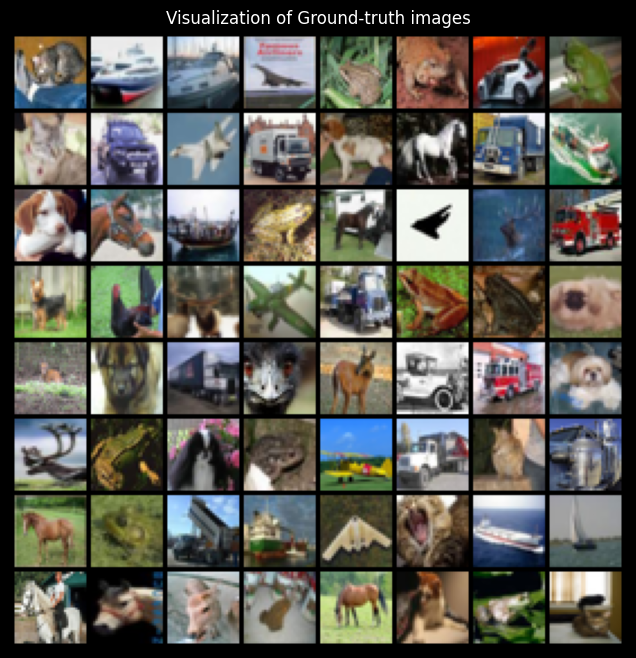

In [15]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

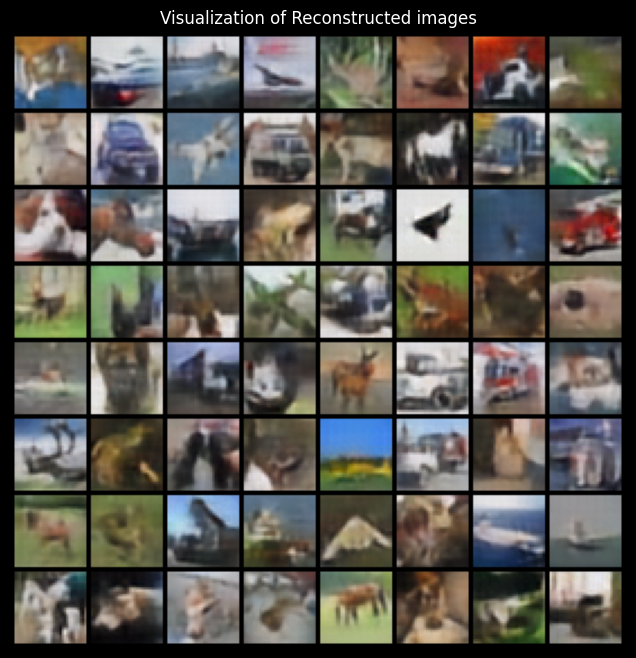

In [16]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [17]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

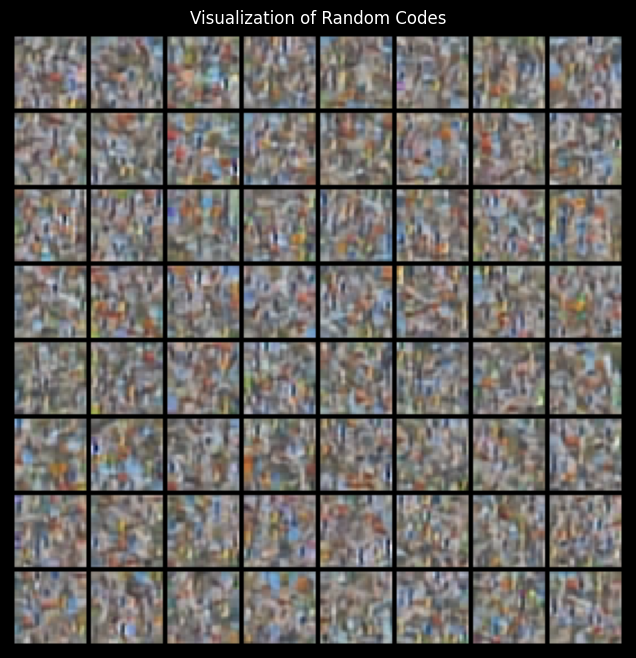

In [18]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, 8, 8))